In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import  *
from pyspark.sql import SQLContext
#Zonder schema wordt de namen van de column onduidelijk zoals col1,col2 ....
crimes_schema = StructType([StructField("ID", StringType(), True),
                            StructField("CaseNumber", StringType(), True),
                            StructField("Date", StringType(), True ),
                            StructField("Block", StringType(), True),
                            StructField("IUCR", StringType(), True),
                            StructField("PrimaryType", StringType(), True  ),
                            StructField("Description", StringType(), True ),
                            StructField("LocationDescription", StringType(), True ),
                            StructField("Arrest", BooleanType(), True),
                            StructField("Domestic", BooleanType(), True),
                            StructField("Beat", StringType(), True),
                            StructField("District", StringType(), True),
                            StructField("Ward", StringType(), True),
                            StructField("CommunityArea", StringType(), True),
                            StructField("FBICode", StringType(), True ),
                            StructField("XCoordinate", DoubleType(), True),
                            StructField("YCoordinate", DoubleType(), True ),
                            StructField("Year", IntegerType(), True),
                            StructField("UpdatedOn", DateType(), True ),
                            StructField("Latitude", DoubleType(), True),
                            StructField("Longitude", DoubleType(), True),
                            StructField("Location", StringType(), True )
                            ])



spark = SparkSession.builder\
                    .master("local[*]")\
                    .config("spark.execute.memory", "1gb")\
                    .appName('Analyzing Bosten and chicago Crime data')\
                    .getOrCreate()

crimes = spark.read.csv("./data/city_of_chicago_crimes_2001_to_present.csv",
                       header = True, 
                        schema = crimes_schema)
sc = spark.sparkContext
sqlContext =SQLContext(sc)

In [2]:
crimes.select('ID','CaseNumber',"Date",'Block','PrimaryType','Description').show(10,truncate=False)

+--------+----------+----------------------+---------------------+------------------+------------------------------+
|ID      |CaseNumber|Date                  |Block                |PrimaryType       |Description                   |
+--------+----------+----------------------+---------------------+------------------+------------------------------+
|11857135|JC468110  |10/10/2019 11:39:00 PM|053XX S LAWNDALE AVE |BATTERY           |DOMESTIC BATTERY SIMPLE       |
|11857005|JC468117  |10/10/2019 11:38:00 PM|040XX W LEXINGTON ST |NARCOTICS         |SOLICIT NARCOTICS ON PUBLICWAY|
|11857045|JC468132  |10/10/2019 11:34:00 PM|048XX S ELIZABETH ST |DECEPTIVE PRACTICE|UNAUTHORIZED VIDEOTAPING      |
|11857374|JC468411  |10/10/2019 11:31:00 PM|0000X N LATROBE AVE  |CRIMINAL DAMAGE   |TO VEHICLE                    |
|11857461|JC468482  |10/10/2019 11:30:00 PM|048XX W CHICAGO AVE  |ROBBERY           |AGGRAVATED                    |
|11857494|JC468546  |10/10/2019 11:30:00 PM|023XX N KEYSTONE AVE

In [3]:
crimes.count()

6988852

In [4]:
crimes.columns

['ID',
 'CaseNumber',
 'Date',
 'Block',
 'IUCR',
 'PrimaryType',
 'Description',
 'LocationDescription',
 'Arrest',
 'Domestic',
 'Beat',
 'District',
 'Ward',
 'CommunityArea',
 'FBICode',
 'XCoordinate',
 'YCoordinate',
 'Year',
 'UpdatedOn',
 'Latitude',
 'Longitude',
 'Location']

In [5]:
crimes.select('Date').show(10,truncate=False)

+----------------------+
|Date                  |
+----------------------+
|10/10/2019 11:39:00 PM|
|10/10/2019 11:38:00 PM|
|10/10/2019 11:34:00 PM|
|10/10/2019 11:31:00 PM|
|10/10/2019 11:30:00 PM|
|10/10/2019 11:30:00 PM|
|10/10/2019 11:24:00 PM|
|10/10/2019 11:23:00 PM|
|10/10/2019 11:20:00 PM|
|10/10/2019 11:15:00 PM|
+----------------------+
only showing top 10 rows



In [6]:
from datetime import datetime
from pyspark.sql.functions import col,udf
myfunc =  udf(lambda x: datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p'), TimestampType())
df =crimes.withColumn('Date_time',myfunc(col('Date'))).drop('Date')
df.select(df["Date_time"]).show(5)

+-------------------+
|          Date_time|
+-------------------+
|2019-10-10 23:39:00|
|2019-10-10 23:38:00|
|2019-10-10 23:34:00|
|2019-10-10 23:31:00|
|2019-10-10 23:30:00|
+-------------------+
only showing top 5 rows



In [7]:
#data = df.groupBy('Year').count().show()
data =df.groupBy('Year').count().sort('Year').collect()
count = [item[1] for item in data]
year = [item[0] for item in data]
data

[Row(Year=2001, count=485760),
 Row(Year=2002, count=486758),
 Row(Year=2003, count=475949),
 Row(Year=2004, count=469390),
 Row(Year=2005, count=453717),
 Row(Year=2006, count=448120),
 Row(Year=2007, count=437027),
 Row(Year=2008, count=427071),
 Row(Year=2009, count=392724),
 Row(Year=2010, count=370354),
 Row(Year=2011, count=351819),
 Row(Year=2012, count=336051),
 Row(Year=2013, count=307178),
 Row(Year=2014, count=275395),
 Row(Year=2015, count=264247),
 Row(Year=2016, count=269203),
 Row(Year=2017, count=268371),
 Row(Year=2018, count=267527),
 Row(Year=2019, count=202191)]

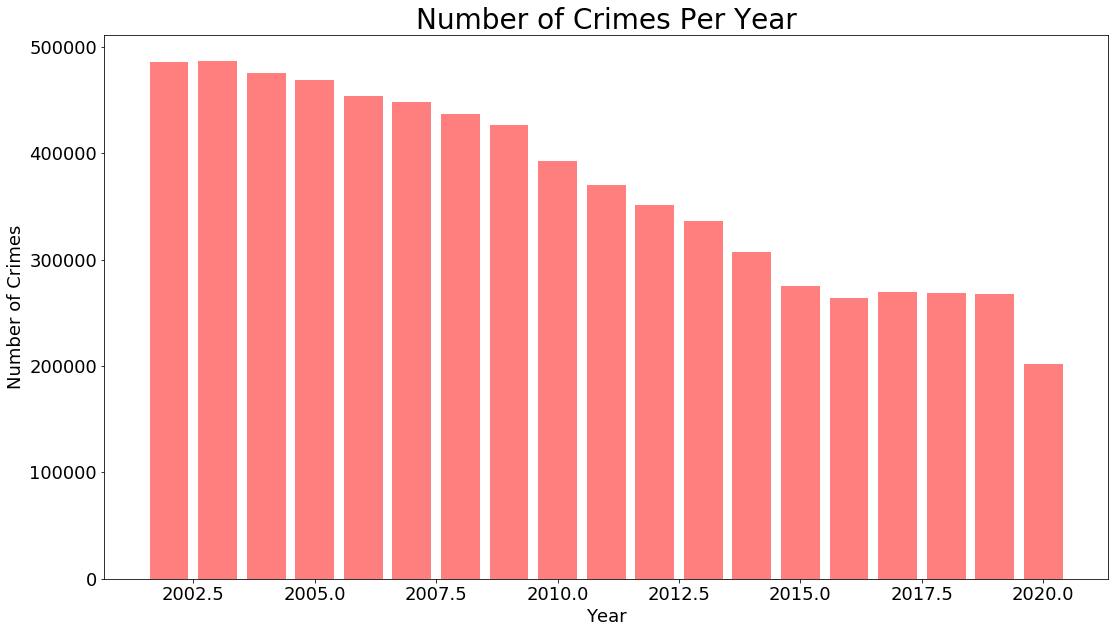

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

x_axis = [i+1 for i in year] 
y_axis= [i for i in count]





fig1 = plt.figure(figsize=(18, 10))
 


plt.xlabel("Year", fontsize = 18)
plt.ylabel("Number of Crimes", fontsize = 18)
plt.title("Number of Crimes Per Year", fontsize = 28)
plt.bar(x_axis, y_axis, fc='red', align='center',alpha=0.5)
plt.xticks(size = 18)
plt.yticks(size = 18)
plt.show()


In [9]:
from pyspark.sql.functions import month
monthdf = df.withColumn("Month",month('Date_time'))
monthCounts = monthdf.select("Month").groupBy("Month").count()
monthCounts = monthCounts.collect()
monthCounts

[Row(Month=12, count=504862),
 Row(Month=1, count=548229),
 Row(Month=6, count=623637),
 Row(Month=3, count=577855),
 Row(Month=5, count=626724),
 Row(Month=9, count=607610),
 Row(Month=4, count=580031),
 Row(Month=8, count=648645),
 Row(Month=7, count=655292),
 Row(Month=10, count=599946),
 Row(Month=11, count=533740),
 Row(Month=2, count=482281)]

In [10]:
monthCounts.sort()
months = [item[0] for item in monthCounts]
count = [item[1] for item in monthCounts]
monthCounts

[Row(Month=1, count=548229),
 Row(Month=2, count=482281),
 Row(Month=3, count=577855),
 Row(Month=4, count=580031),
 Row(Month=5, count=626724),
 Row(Month=6, count=623637),
 Row(Month=7, count=655292),
 Row(Month=8, count=648645),
 Row(Month=9, count=607610),
 Row(Month=10, count=599946),
 Row(Month=11, count=533740),
 Row(Month=12, count=504862)]

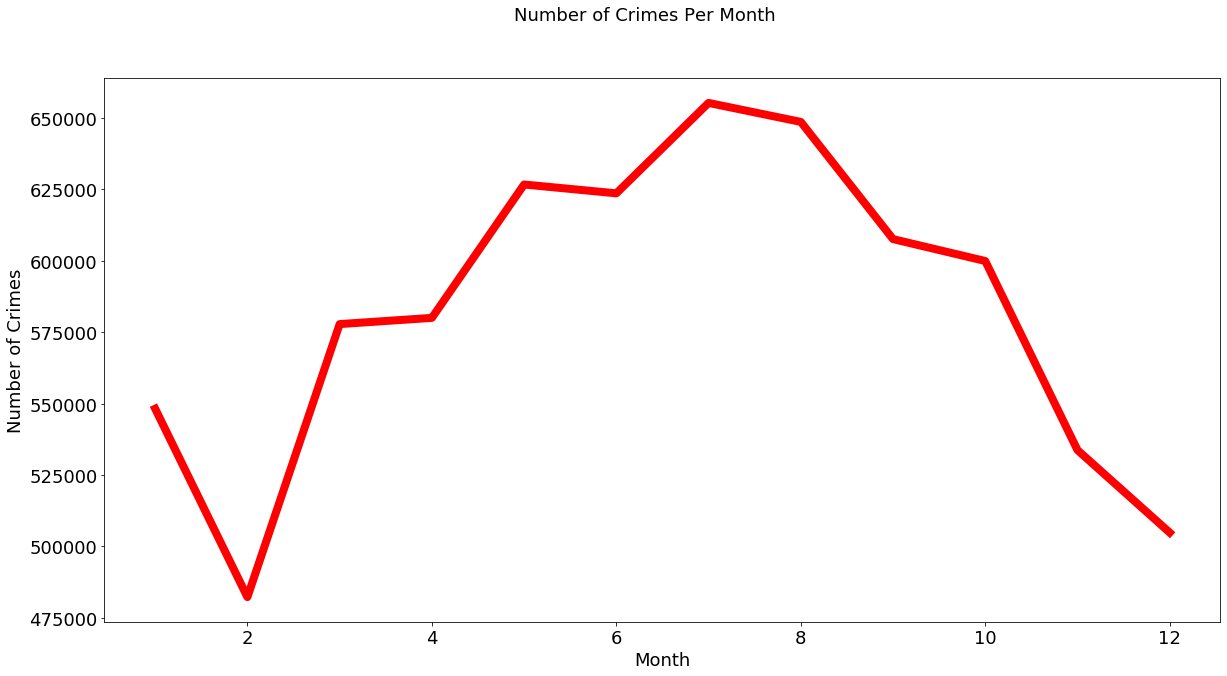

In [11]:
x_axis = [i for i in months] 
y_axis= [i for i in count]

fig = plt.figure(figsize=(20,10))
fig.suptitle('Number of Crimes Per Month', fontsize=18)
plt1 = fig.add_subplot(111)
 
plt.xlabel("Month", fontsize = 18)
plt.ylabel("Number of Crimes", fontsize = 18)
plt.plot(x_axis,y_axis,linewidth = 8,color = "red")
plt.xticks(size = 18)
plt.yticks(size = 18)
plt.show()

In [12]:
crime_location  = crimes.groupBy("LocationDescription").count().sort('count', ascending  = False).limit(20).collect()
crime_location

[Row(LocationDescription='STREET', count=1823012),
 Row(LocationDescription='RESIDENCE', count=1183071),
 Row(LocationDescription='APARTMENT', count=729645),
 Row(LocationDescription='SIDEWALK', count=684130),
 Row(LocationDescription='OTHER', count=266486),
 Row(LocationDescription='PARKING LOT/GARAGE(NON.RESID.)', count=200625),
 Row(LocationDescription='ALLEY', count=155557),
 Row(LocationDescription='SCHOOL, PUBLIC, BUILDING', count=145233),
 Row(LocationDescription='RESIDENCE-GARAGE', count=134663),
 Row(LocationDescription='SMALL RETAIL STORE', count=125572),
 Row(LocationDescription='RESIDENCE PORCH/HALLWAY', count=122356),
 Row(LocationDescription='VEHICLE NON-COMMERCIAL', count=112737),
 Row(LocationDescription='RESTAURANT', count=112052),
 Row(LocationDescription='GROCERY FOOD STORE', count=90411),
 Row(LocationDescription='DEPARTMENT STORE', count=88010),
 Row(LocationDescription='GAS STATION', count=75415),
 Row(LocationDescription='RESIDENTIAL YARD (FRONT/BACK)', count=739

In [13]:
location = [item[0] for item in crime_location]
count = [item[1] for item in crime_location]
location

['STREET',
 'RESIDENCE',
 'APARTMENT',
 'SIDEWALK',
 'OTHER',
 'PARKING LOT/GARAGE(NON.RESID.)',
 'ALLEY',
 'SCHOOL, PUBLIC, BUILDING',
 'RESIDENCE-GARAGE',
 'SMALL RETAIL STORE',
 'RESIDENCE PORCH/HALLWAY',
 'VEHICLE NON-COMMERCIAL',
 'RESTAURANT',
 'GROCERY FOOD STORE',
 'DEPARTMENT STORE',
 'GAS STATION',
 'RESIDENTIAL YARD (FRONT/BACK)',
 'CHA PARKING LOT/GROUNDS',
 'PARK PROPERTY',
 'COMMERCIAL / BUSINESS OFFICE']

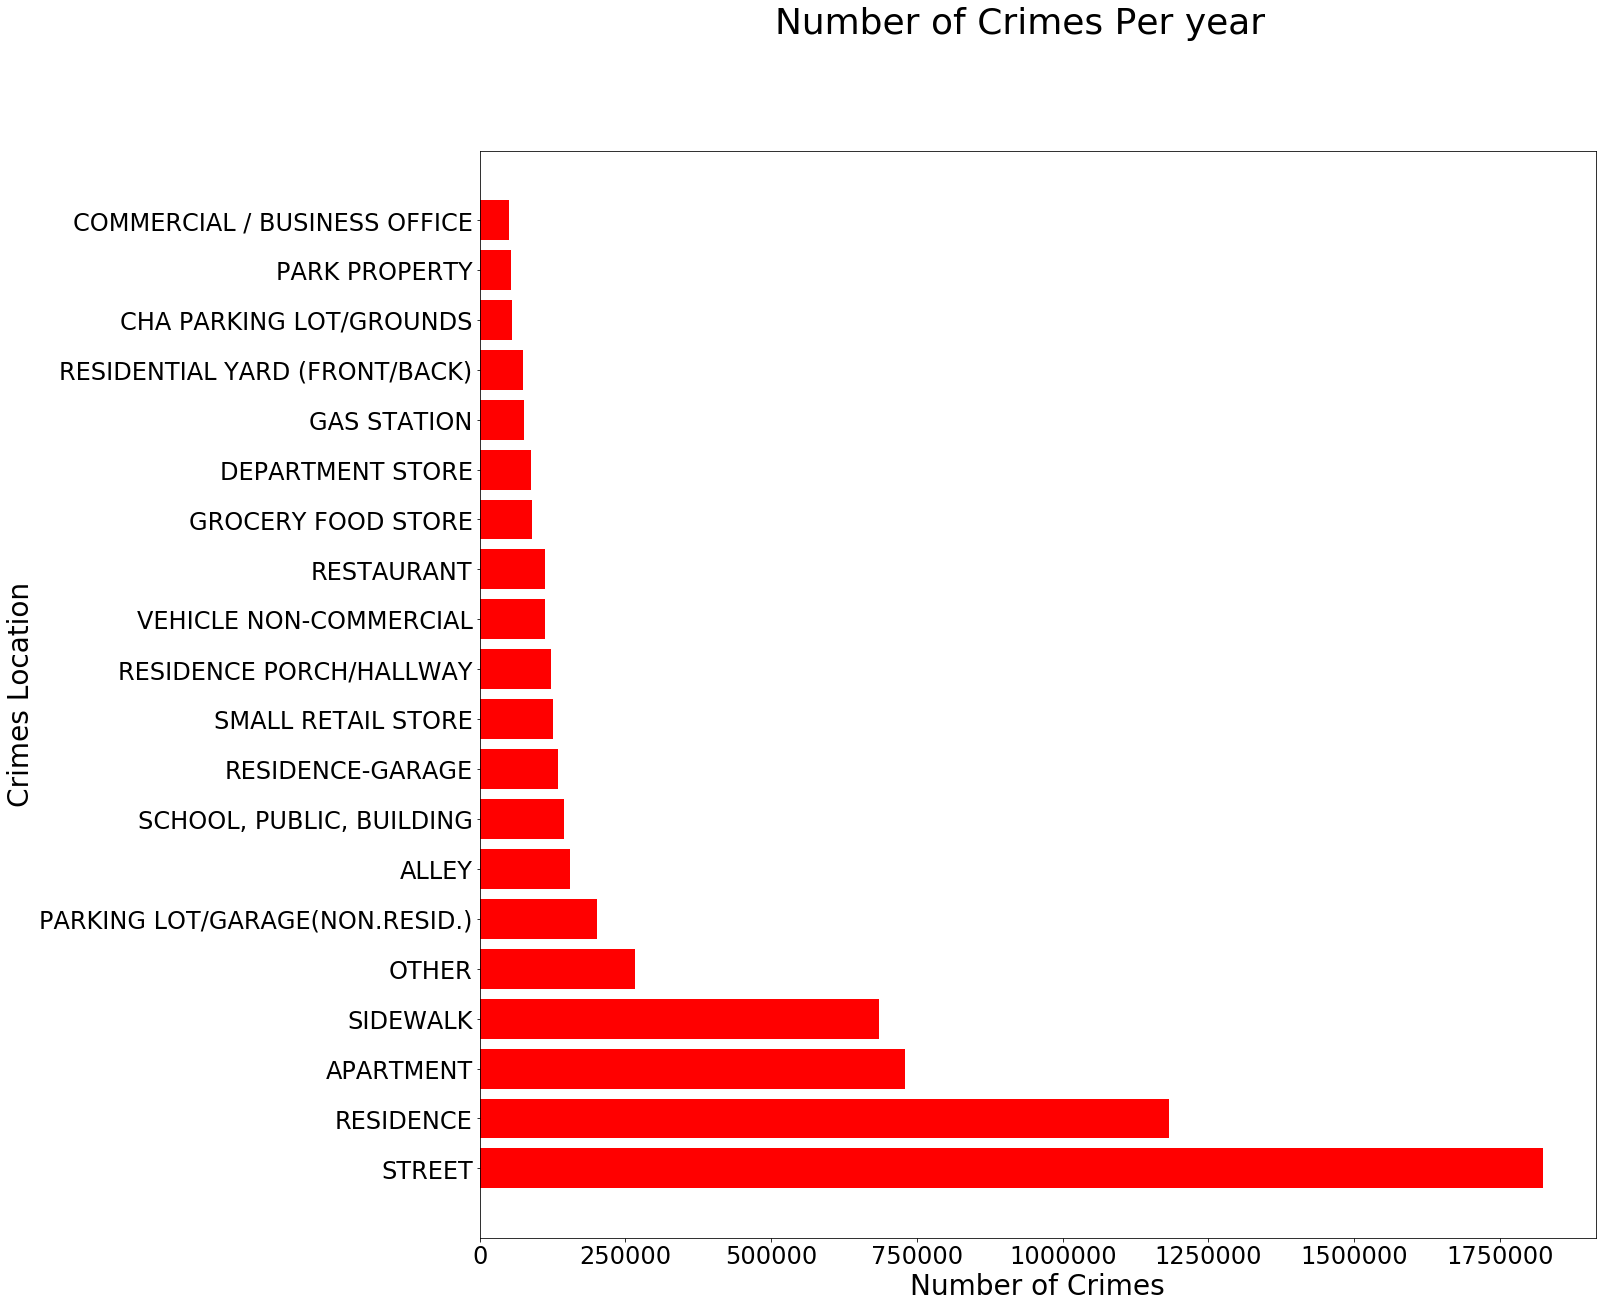

In [14]:
x_axis = [i for i in location] 
y_axis= [i for i in count]

fig = plt.figure(figsize=(20,20))
fig.suptitle('Number of Crimes Per year', fontsize=36)
 
plt.xlabel("Number of Crimes", fontsize = 28)
plt.ylabel("Crimes Location", fontsize = 28)
plt.barh(x_axis,y_axis,color = "red")
plt.xticks(size = 24)
plt.yticks(size = 24)
plt.show()

In [15]:
crime_Coordinates  = crimes.groupBy("Latitude","longitude").count().sort('count', ascending  = False).limit(50).collect()
crime_Coordinates.pop(0)
map_location = [[item[0],item[1],item[2]] for item in crime_Coordinates]
long_lat=[[item[0],item[1]] for item in map_location]       
long_lat.pop(0)
count=[item[2] for item in map_location]
map_location

[[41.976290414, -87.905227221, 13380],
 [41.754592961, -87.741528537, 9650],
 [41.883500187, -87.627876698, 7400],
 [41.897895128, -87.624096605, 4549],
 [41.896888586, -87.628203192, 3253],
 [41.909664252, -87.742728815, 3188],
 [41.885487535, -87.726422045, 2810],
 [41.788987036, -87.74147999, 2561],
 [41.904192368, -87.647000785, 2545],
 [41.88233367, -87.627841791, 2534],
 [41.736259984, -87.628068782, 2465],
 [41.721627204, -87.624485177, 2424],
 [41.737094305, -87.572998178, 2356],
 [41.68995741, -87.637460623, 2275],
 [41.891990384, -87.611461502, 2266],
 [41.979006297, -87.906463155, 2262],
 [41.739265865, -87.604893749, 2202],
 [41.868180939, -87.709271389, 2199],
 [41.736148121, -87.629070243, 2122],
 [41.868541914, -87.639235361, 2116],
 [42.019399237, -87.675049485, 2064],
 [41.706070186, -87.653645803, 2031],
 [41.882394062, -87.627844798, 2021],
 [41.899410159, -87.624131266, 2004],
 [41.750940757, -87.625185222, 1997],
 [41.814007401, -87.628331665, 1957],
 [41.929743818

In [16]:
import folium
from folium.plugins import HeatMap
first_map = folium.Map(location=[41.885487535, -87.726422045], zoom_start=13)
HeatMap(long_lat,name=None, min_opacity=0.5, max_zoom=18, max_val=1.0, radius=25, blur=10, gradient=None, overlay=True, control=True, show=True).add_to(first_map)

first_map

In [17]:
yearCount = crimes.groupBy("YEAR").count().orderBy("YEAR")#.groupBy("YEAR").count().orderBy("YEAR").show()

In [22]:
income_schema = StructType([StructField("ID Year", StringType(), True),
                            StructField("Year", StringType(), True),
                            StructField("Income", IntegerType(), True),
                            StructField("Household Income by Race Moe", StringType(), True),
                            StructField("Geography", StringType(), True),
                            StructField("ID Geography", StringType(), True),
                            StructField("Slug", StringType(), True)])

income = spark.read.csv("./data/ChicagoHouseholdIncome.csv", header = True, schema = income_schema)

In [23]:
income.show()

+-------+----+------+----------------------------+--------------------+--------------+--------------------+
|ID Year|Year|Income|Household Income by Race Moe|           Geography|  ID Geography|                Slug|
+-------+----+------+----------------------------+--------------------+--------------+--------------------+
|   2017|2017| 55295|                        1185|     Chicago, IL, IL|16000US1714000|          chicago-il|
|   2017|2017| 68403|                         790|Chicago-Napervill...|  31000US16980|chicago-joliet-na...|
|   2017|2017| 60336|                          86|       United States|       01000US|       united-states|
|   2017|2017| 61405|                         665|     Cook County, IL|  05000US17031|      cook-county-il|
|   2017|2017| 89521|                        2135|   DuPage County, IL|  05000US17043|    dupage-county-il|
|   2017|2017| 62992|                         544|            Illinois|     04000US17|            illinois|
|   2016|2016| 57617|       

In [26]:
income.registerTempTable('chicagoIncome')

chicagoIncomeData = sqlContext.sql("Select * From chicagoIncome where Slug Like 'chicago%'").groupBy("Year").sum("income").orderBy('Year')
chicagoIncomeData.show()

+----+-----------+
|Year|sum(income)|
+----+-----------+
|2013|     107663|
|2014|     110332|
|2015|     113855|
|2016|     119026|
|2017|     123698|
+----+-----------+



In [ ]:
chicagoIncome.show()

In [ ]:
chicago_year_count=crimes.groupBy("YEAR").count().orderBy("YEAR")#.groupBy("YEAR").count().orderBy("YEAR").show()

In [ ]:
chicago_year_count.show()

In [ ]:
import numpy as np 
x_axies = [i[0] for i in chicagoIncomeData.select("sum(Income)").limit(5).collect()]
y_axies = [i[1] for i in chicago_year_count.filter('YEAR >= 2013 AND YEAR <= 2018').orderBy("YEAR").limit(5).collect()]

data = [x_axies, y_axies]
years = ["2013","2014","2015","2016","2017"]
X = np.arange(len(years))

plt.title('Crime VS incom in chicago', fontsize=20)
plt.bar(X + 0.15, data[1], color = '#ff5252', width = 0.30, label = 'Crime ')
plt.bar(X - 0.15, data[0], color = '#9dff52', width = 0.30, label = 'Income')

ax = plt.gca()
ax.legend(shadow=True)
plt.xticks(X,(years))
plt.show()